#Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import os
import requests
import zipfile

import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D, GlobalAveragePooling1D, Layer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import lime.lime_text
import shap
from captum.attr import IntegratedGradients
import tensorflow_probability as tfp

sns.set(style='whitegrid', palette='muted', font_scale=1.2)


#Data Loading and Preprocessing

In [2]:
# Load data
df = pd.read_csv('Training_Essay_Data.csv', encoding='latin1')




In [3]:
# Data Preprocessing and Cleaning
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text


In [4]:
df['clean_text'] = df['text'].apply(clean_text)



In [5]:
# Tokenization, stopwords removal, and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()



In [6]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens



In [7]:
df['tokens'] = df['clean_text'].apply(preprocess_text)


#Load Glove Embedding

In [8]:
# Download and unzip GloVe embeddings
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
filename = 'glove.6B.zip'

response = requests.get(url)
with open(filename, 'wb') as f:
    f.write(response.content)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('glove.6B')


In [9]:

# Load GloVe embeddings
def load_glove_embeddings(filepath, embedding_dim=100):
    glove_embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings[word] = vector
    return glove_embeddings


In [10]:

glove_filepath = 'glove.6B/glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_filepath, embedding_dim=100)


#Data Preparation

In [11]:
# Convert text data into numerical representations
max_seq_length = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
X_seq = tokenizer.texts_to_sequences(df['clean_text'])
X_pad = pad_sequences(X_seq, maxlen=max_seq_length)




In [12]:
# Define features (X) and target variable (y)
X = X_pad
y = df['generated']


In [13]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


#Attention Layer Defintion

In [14]:
# Define the Attention layer
class Attention(Layer):
    def __init__(self, return_sequences=True):
        super(Attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.activations.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.activations.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return tf.keras.backend.sum(output, axis=1)


#Create Embedding Matrix

In [15]:
# Function to create embedding matrix
def create_embedding_matrix(tokenizer, embeddings_index, embedding_dim):
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix



In [16]:
# Prepare embedding matrix for GloVe
embedding_matrix_glove = create_embedding_matrix(tokenizer, glove_embeddings, 100)


#Define and Train LSTM Model

In [17]:
# Define LSTM model with embeddings and attention
def create_lstm_model(input_dim, output_dim, max_sequence_length, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim, output_dim, input_length=max_sequence_length,
                        embeddings_initializer=Constant(embedding_matrix),
                        trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Attention(return_sequences=True))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
    return model



In [19]:
from tensorflow.keras.metrics import Precision, Recall, AUC

In [20]:
lstm_model_glove = create_lstm_model(len(tokenizer.word_index) + 1, 100, max_seq_length, embedding_matrix_glove)



In [21]:
# Train the LSTM model with GloVe embeddings
history_glove = lstm_model_glove.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32)


Epoch 1/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.6676 - auc: 0.7127 - loss: 0.6390 - precision: 0.7593 - recall: 0.1106 - val_accuracy: 0.6938 - val_auc: 0.9004 - val_loss: 0.5542 - val_precision: 0.9545 - val_recall: 0.1674
Epoch 2/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7234 - auc: 0.8635 - loss: 0.5377 - precision: 0.8898 - recall: 0.2621 - val_accuracy: 0.8824 - val_auc: 0.9329 - val_loss: 0.4469 - val_precision: 0.9235 - val_recall: 0.7382
Epoch 3/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8722 - auc: 0.9152 - loss: 0.4361 - precision: 0.8820 - recall: 0.7502 - val_accuracy: 0.8993 - val_auc: 0.9555 - val_loss: 0.3368 - val_precision: 0.8647 - val_recall: 0.8578
Epoch 4/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8973 - auc: 0.9442 - loss: 0.3461 - precision: 0.8960 - recall: 0.8124 - val_accuracy: 0.9003 - val_auc: 0.9631 - val_loss: 0.2934 - val_precision: 0.8217 - val_recall: 0.9276
Epoch 5/40
603/603 ━━━━━

#Evaluate Model

In [22]:
# Evaluate the LSTM model on the test set
y_pred_nn = (lstm_model_glove.predict(X_test) > 0.5).astype(int)
print(f"LSTM Model Test Accuracy: {accuracy_score(y_test, y_pred_nn):.2f}")
print(classification_report(y_test, y_pred_nn))




130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
LSTM Model Test Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2608
           1       0.98      0.96      0.97      1523

    accuracy                           0.98      4131
   macro avg       0.98      0.97      0.98      4131
weighted avg       0.98      0.98      0.98      4131



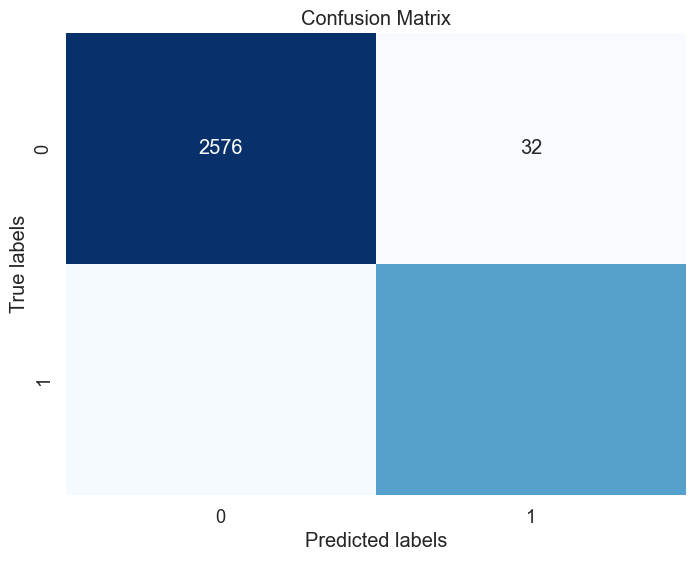

In [23]:

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


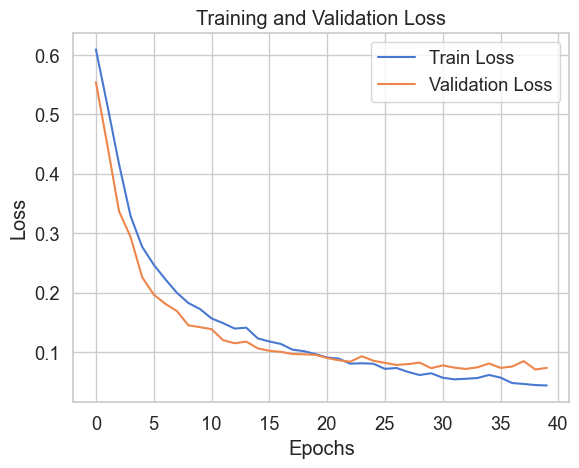

In [24]:
# Plot training history
plt.plot(history_glove.history['loss'], label='Train Loss')
plt.plot(history_glove.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# ROC-AUC
test_loss, test_acc, test_recall, test_precision, test_auc = lstm_model_glove.evaluate(X_test_pad, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test AUC:", test_auc)


In [25]:
# ROC-AUC
y_pred_proba = lstm_model_glove.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)
print("Test ROC-AUC:", roc_auc_value)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Test ROC-AUC: 0.9971288907508188


#Explainability with LIME and SHAP

In [ ]:
lstm_model_glove.save('lstm_model_Glove_FINAL00.h5')

In [ ]:
keras.saving.save_model(lstm_model_glove, 'lstm_model_Glove_FINAL0.keras')

In [ ]:
import shap
import numpy as np

In [ ]:
# Example: Assuming X_shap is a subset of your validation data
X_shap = X_val[:100]  # Selecting first 100 examples for explanation (adjust as needed)


In [ ]:
# Example: Wrap your model with a function for SHAP compatibility
def model_wrapper(x):
    # Adjust x if needed (e.g., reshape for LSTM input)
    return lstm_model_glove.predict(x)

explainer = shap.Explainer(model_wrapper, X_shap)


In [ ]:
shap_values = explainer(X_shap)


In [ ]:
# Convert dict_keys object to a list
feature_names_list = list(tokenizer.word_index.keys())


In [ ]:
# Example: Summary plot of SHAP values
shap.summary_plot(shap_values, X_shap, feature_names=feature_names_list)


In [ ]:
import lime
import lime.lime_text
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
# Prepare text data for LIME
def prepare_text_for_lime(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)
    return padded_sequences

In [ ]:
explainer = lime.lime_text.LimeTextExplainer()


In [ ]:
idx = 0  # Change this index to select different examples

In [ ]:
X_explain_text = df['clean_text'].iloc[idx]  # Adjust as per your data structure
X_explain = prepare_text_for_lime([X_explain_text])

In [ ]:
def predict_fn(texts):
    # Assuming bayesian_lstm_model_word2vec is your Keras model
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)
    return lstm_model_glove.predict(padded_sequences)



In [ ]:
import lime
import lime.lime_text
from lime.lime_text import LimeTextExplainer

In [ ]:
# LIME
explainer = LimeTextExplainer(class_names=['Non Generated', 'Generated'])
idx = 0
sample_text = df['clean_text'].iloc[idx]


In [ ]:
def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    return np.array([[1-p, p] for p in lstm_model_glove.predict(padded).flatten()])



In [ ]:
input_dim = len(tokenizer.word_index) + 1
output_dim = 100
max_sequence_length = X_pad.shape[1]

In [ ]:
exp = explainer.explain_instance(sample_text, predict_proba, num_features=10)
exp.show_in_notebook(text=sample_text)


In [ ]:
text_to_explain = df['clean_text'].iloc[idx]

In [ ]:
# Choose an example text to explain
idx = 0  # Change this index to select different examples
text_to_explain = df['clean_text'].iloc[idx]
true_label = df['generated'].iloc[idx]


In [ ]:
# For terminal visualization
print('Document id: %d' % idx)
print('Probability(G):', predict_proba([text_to_explain])[0, 1])
print('True class: %s' % true_label)
exp.show_in_notebook(text=True)


In [ ]:
# Function to predict probabilities for LIME explainer
def predict_proba(texts):
    seq = tokenizer.texts_to_sequences(texts)
    padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_sequence_length)
    preds = lstm_model_glove.predict(padded)
    return np.hstack((1 - preds, preds))


In [ ]:
# Initialize LIME text explainer
explainer = LimeTextExplainer(class_names=['Non Generated', 'Generated'])



In [ ]:
# Choose an example text to explain
idx = 0  # Change this index to select different examples
text_to_explain = df['clean_text'].iloc[idx]
true_label = df['generated'].iloc[idx]



In [ ]:
# Explain the prediction of the example text
exp = explainer.explain_instance(text_to_explain, predict_proba, num_features=10)


In [ ]:
# Visualize the explanation
exp.show_in_notebook(text=True)


In [ ]:
# For terminal visualization
print('Document id: %d' % idx)
print('Probability(G):', predict_proba([text_to_explain])[0, 1])
print('True class: %s' % true_label)
exp.show_in_notebook(text=True)


In [ ]:
# Plot LIME explanations as a bar chart
fig = exp.as_pyplot_figure()
plt.show()

In [ ]:
# 1. Feature Importance Bar Chart
plt.figure(figsize=(10, 5))
exp.as_list()
weights = dict(exp.as_list())
plt.barh(list(weights.keys()), list(weights.values()), color='b')
plt.xlabel('Weight')
plt.title('Feature Importance for the given text')
plt.show()



In [ ]:
# 3. Comparison of Predictions for Multiple Texts
texts_to_explain = df['clean_text'].iloc[:5]  # Change to select different examples
for i, text in enumerate(texts_to_explain):
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    fig = exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for Text {i}')
    plt.show()

In [ ]:
# Additional Visualizations

# 1. Feature Importance Bar Chart
plt.figure(figsize=(10, 5))
exp.as_list()
weights = dict(exp.as_list())
plt.barh(list(weights.keys()), list(weights.values()), color='b')
plt.xlabel('Weight')
plt.title('Feature Importance for the given text')
plt.show()


In [ ]:
# 3. Comparison of Predictions for Multiple Texts
texts_to_explain = df['clean_text'].iloc[:5]  # Change to select different examples
for i, text in enumerate(texts_to_explain):
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    fig = exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for Text {i}')
    plt.show()


In [ ]:
# 5. Distribution of Prediction Probabilities
y_pred_proba = lstm_model_glove.predict(X_test_pad)
plt.figure(figsize=(10, 5))
sns.histplot(y_pred_proba, bins=50, kde=True)
plt.xlabel('Predicted Probability of Generated Class')
plt.title('Distribution of Prediction Probabilities')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D, GlobalAveragePooling1D, Layer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, TFBertForSequenceClassification
import torch
import lime
import lime.lime_text
from lime.lime_text import LimeTextExplainer
import shap
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from transformers import pipeline
from tensorflow.keras.models import load_model

In [ ]:
word_weights = dict(exp.as_list())

In [ ]:
# 6. Cumulative Feature Importance
sorted_weights = sorted(word_weights.values(), reverse=True)
cumulative_importance = np.cumsum(sorted_weights) / np.sum(sorted_weights)
plt.figure(figsize=(10, 5))
plt.plot(cumulative_importance, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid()
plt.show()

In [ ]:
# 7. Feature Contribution Bar Chart for Multiple Samples
num_samples = 5
texts_to_explain = df['clean_text'].iloc[:num_samples]  # Change to select different examples
fig, axes = plt.subplots(num_samples, 1, figsize=(10, 15))
for i, text in enumerate(texts_to_explain):
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    weights = dict(exp.as_list())
    axes[i].barh(list(weights.keys()), list(weights.values()), color='b')
    axes[i].set_title(f'Sample {i} Feature Importance')
    axes[i].set_xlabel('Weight')
fig.tight_layout()
plt.show()


In [ ]:
# 9. Feature Contribution Distribution
feature_contributions = []
for text in df['clean_text'].iloc[:100]:  # Change to analyze more samples
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    weights = dict(exp.as_list())
    feature_contributions.extend(list(weights.values()))

plt.figure(figsize=(10, 5))
sns.histplot(feature_contributions, bins=50, kde=True)
plt.xlabel('Feature Contribution')
plt.title('Distribution of Feature Contributions')
plt.show()


In [ ]:
# 10. Partial Dependence Plot
def partial_dependence_plot(text, feature_index):
    seq = tokenizer.texts_to_sequences([text])[0]
    feature_values = np.linspace(0, np.max(seq), num=20).astype(int)
    predictions = []
    for value in feature_values:
        temp_seq = seq.copy()
        temp_seq[feature_index] = value
        padded = tf.keras.preprocessing.sequence.pad_sequences([temp_seq], maxlen=max_sequence_length)
        preds = lstm_model_glove.predict(padded)
        predictions.append(preds[0][0])
    
    plt.figure(figsize=(10, 5))
    plt.plot(feature_values, predictions, marker='o')
    plt.xlabel('Feature Value')
    plt.ylabel('Predicted Probability')
    plt.title(f'Partial Dependence Plot for Feature at Index {feature_index}')
    plt.grid()
    plt.show()

partial_dependence_plot(text_to_explain, 5)  # Change the feature index to analyze different features


In [ ]:
# 11. Cumulative Importance of Features for Multiple Samples
num_samples = 5
texts_to_explain = df['clean_text'].iloc[:num_samples]  # Change to select different examples
cumulative_importances = []
for text in texts_to_explain:
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    weights = sorted(dict(exp.as_list()).values(), reverse=True)
    cumulative_importance = np.cumsum(weights) / np.sum(weights)
    cumulative_importances.append(cumulative_importance)

plt.figure(figsize=(10, 5))
for i, cum_importance in enumerate(cumulative_importances):
    plt.plot(cum_importance, marker='o', label=f'Sample {i}')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importance of Features for Multiple Samples')
plt.legend()
plt.grid()
plt.show()